In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TU Delft/Master/Deep Learning/Reproducability Project

/content/drive/.shortcut-targets-by-id/1DuKt88mVXJTHanb5KcuJgrsmJcTSkPkb/Reproducability Project


In [ ]:
pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install rawpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.0 MB/s eta 0:00:00


In [ ]:
# uniform content loss + adaptive threshold + per_class_input + recursive G
# improvement upon cqf37
from __future__ import division
import os, time, scipy.io
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as slim
import numpy as np
import rawpy
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
input_dir = './dataset/Sony/short/'
gt_dir = './dataset/Sony/long/'
checkpoint_dir = './checkpoint/RMSprop_lr0.1/'
result_dir = './result_RMSprop_lr0.1/' 

# get train IDs
train_fns = glob.glob(gt_dir + '0*.ARW')
train_ids = [int(os.path.basename(train_fn)[0:5]) for train_fn in train_fns]
print(len(train_ids))
ps = 512  # patch size for training
save_freq = 500
num_epochs = 4000

161


In [ ]:
#set different debug schemes
DEBUG = 2
if DEBUG == 1:
    save_freq = 2
    train_ids = train_ids[0:5]
    num_epochs = 10
if DEBUG == 2:
    save_freq = 5
    train_ids = train_ids[0:40]
    num_epochs = 15

print(len(train_ids))

40


In [ ]:
def lrelu(x):
    return tf.maximum(x * 0.2, x)

def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)


def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

def upsample_and_concat(x1, x2, output_channels, in_channels):
    pool_size = 2
    deconv_filter = tf.Variable(tf.truncated_normal([pool_size, pool_size, output_channels, in_channels], stddev=0.02))
    deconv = tf.nn.conv2d_transpose(x1, deconv_filter, tf.shape(x2), strides=[1, pool_size, pool_size, 1])

    deconv_output = tf.concat([deconv, x2], 3)
    deconv_output.set_shape([None, None, None, output_channels * 2])

    return deconv_output


def network(input):
    conv1 = slim.conv2d(input, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_1')
    conv1 = slim.conv2d(conv1, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_2')
    pool1 = slim.max_pool2d(conv1, [2, 2], padding='SAME')

    conv2 = slim.conv2d(pool1, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_1')
    conv2 = slim.conv2d(conv2, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_2')
    pool2 = slim.max_pool2d(conv2, [2, 2], padding='SAME')

    conv3 = slim.conv2d(pool2, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_1')
    conv3 = slim.conv2d(conv3, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_2')
    pool3 = slim.max_pool2d(conv3, [2, 2], padding='SAME')

    conv4 = slim.conv2d(pool3, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_1')
    conv4 = slim.conv2d(conv4, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_2')
    pool4 = slim.max_pool2d(conv4, [2, 2], padding='SAME')

    conv5 = slim.conv2d(pool4, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_1')
    conv5 = slim.conv2d(conv5, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_2')

    up6 = upsample_and_concat(conv5, conv4, 256, 512)
    conv6 = slim.conv2d(up6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_1')
    conv6 = slim.conv2d(conv6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_2')

    up7 = upsample_and_concat(conv6, conv3, 128, 256)
    conv7 = slim.conv2d(up7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_1')
    conv7 = slim.conv2d(conv7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_2')

    up8 = upsample_and_concat(conv7, conv2, 64, 128)
    conv8 = slim.conv2d(up8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_1')
    conv8 = slim.conv2d(conv8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_2')

    up9 = upsample_and_concat(conv8, conv1, 32, 64)
    conv9 = slim.conv2d(up9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_1')
    conv9 = slim.conv2d(conv9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_2')

    conv10 = slim.conv2d(conv9, 12, [1, 1], rate=1, activation_fn=None, scope='g_conv10')
    out = tf.depth_to_space(conv10, 2)
    return out


def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    black = raw.black_level_per_channel
    im = np.maximum((im - np.mean(black)), 0) / ((16383) - np.mean(black))  # subtract the black level
  
    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
  
    H = img_shape[0]
    W = img_shape[1]
    if (raw.raw_pattern == ([[1, 0], [2, 3]])).all():
      G = im[0:H:2, 0:W:2, :] # Every alternating value starting from position (0,0) 
      R = im[0:H:2, 1:W:2, :] # Every alternating value starting from position (0,1) 
      G_e = im[1:H:2, 1:W:2, :] # Every alternating value starting from position (1,1) 
      B = im[1:H:2, 0:W:2, :] # Every alternating value starting from position (1,0)
    if (raw.raw_pattern == ([[0, 1], [3, 2]])).all():
      R = im[0:H:2, 0:W:2, :] # Every alternating value starting from position (0,0) 
      G = im[0:H:2, 1:W:2, :] # Every alternating value starting from position (0,1) 
      B = im[1:H:2, 1:W:2, :] # Every alternating value starting from position (1,1) 
      G_e = im[1:H:2, 0:W:2, :] # Every alternating value starting from position (1,0)  
    if (raw.raw_pattern == ([[1, 2], [0, 3]])).all():
      G = im[0:H:2, 0:W:2, :] # Every alternating value starting from position (0,0) 
      B = im[0:H:2, 1:W:2, :] # Every alternating value starting from position (0,1) 
      G_e = im[1:H:2, 1:W:2, :] # Every alternating value starting from position (1,1) 
      R = im[1:H:2, 0:W:2, :] # Every alternating value starting from position (1,0)
    if (raw.raw_pattern == ([[2, 1], [3, 0]])).all():
      B = im[0:H:2, 0:W:2, :] # Every alternating value starting from position (0,0) 
      G = im[0:H:2, 1:W:2, :] # Every alternating value starting from position (0,1) 
      R = im[1:H:2, 1:W:2, :] # Every alternating value starting from position (1,1) 
      G_e = im[1:H:2, 0:W:2, :] # Every alternating value starting from position (1,0)
    out = np.concatenate((R, G, B, G_e), axis=2) # Always in R-G-B-G format
    
    return out



In [ ]:
sess = tf.Session()
in_image = tf.placeholder(tf.float32, [None, None, None, 4])
gt_image = tf.placeholder(tf.float32, [None, None, None, 3])
out_image = network(in_image)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
G_loss = tf.reduce_mean(tf.abs(out_image - gt_image))

t_vars = tf.trainable_variables()
lr = tf.placeholder(tf.float32)
# G_opt = tf.train.AdagradOptimizer(learning_rate=lr).minimize(G_loss)
# G_opt = tf.compat.v1.train.AdadeltaOptimizer(learning_rate=1.0).minimize(G_loss)
G_opt = tf.compat.v1.train.RMSPropOptimizer(learning_rate=0.1).minimize(G_loss) 

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded ' + ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)

# Raw data takes long time to load. Keep them in memory after loaded.
gt_images = [None] * 6000
input_images = {}
input_images['300'] = [None] * len(train_ids)
input_images['250'] = [None] * len(train_ids)
input_images['100'] = [None] * len(train_ids)

g_loss = np.zeros((5000, 1))

allfolders = glob.glob(result_dir + '*0')
lastepoch = 0
for folder in allfolders:
    lastepoch = np.maximum(lastepoch, int(folder[-4:]))

losses = []
times = []

print('Debug scheme: ', DEBUG, 'Nr. images: ', len(train_ids))

learning_rate = 1e-4
for epoch in range(lastepoch, num_epochs+1):
    if os.path.isdir(result_dir + '%04d' % epoch):
        continue
    cnt = 0
    if epoch > 2000:
        learning_rate = 1e-5

    for ind in np.random.permutation(len(train_ids)):
        # get the path from image id
        train_id = train_ids[ind]
        print(train_id)
        in_files = glob.glob(input_dir + '%05d_00*.ARW' % train_id)
        print(len(in_files))
        in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        st = time.time()
        cnt += 1

        if input_images[str(ratio)[0:3]][ind] is None:
            raw = rawpy.imread(in_path)
            input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

        # crop
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))

        input_patch = np.minimum(input_patch, 1.0)

        _, G_current, output = sess.run([G_opt, G_loss, out_image],
                                        feed_dict={in_image: input_patch, gt_image: gt_patch, lr: learning_rate})
        output = np.minimum(np.maximum(output, 0), 1)
        g_loss[ind] = G_current

        print("%d %d Loss=%.3f Time=%.3f" % (epoch, cnt, np.mean(g_loss[np.where(g_loss)]), time.time() - st))
        losses.append(np.mean(g_loss[np.where(g_loss)]))
        times.append(time.time() - st)
        if epoch % save_freq == 0:
            if not os.path.isdir(result_dir + '%04d' % epoch):
                os.makedirs(result_dir + '%04d' % epoch)

            temp = np.concatenate((gt_patch[0, :, :, :], output[0, :, :, :]), axis=1)
            toimage(temp * 255, high=255, low=0, cmin=0, cmax=255).save(
                result_dir + '%04d/%05d_00_train_%d.jpg' % (epoch, train_id, ratio))

    saver.save(sess, checkpoint_dir + 'model.ckpt')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Debug scheme:  2 Nr. images:  40
110
1


<ipython-input-10-fa6d1088910b>:49: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]


0 1 Loss=0.089 Time=21.345
72

<ipython-input-8-ef9c8e6e316a>:157: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()



1
0 2 Loss=0.250 Time=19.154
99
1
0 3 Loss=0.209 Time=66.525
85
1
0 4 Loss=0.215 Time=14.877
96
1
0 5 Loss=0.213 Time=15.214
119
1
0 6 Loss=0.199 Time=14.905
113
1
0 7 Loss=0.187 Time=14.586
114
1
0 8 Loss=0.168 Time=14.675
130
1
0 9 Loss=0.168 Time=16.223
81
1
0 10 Loss=0.180 Time=15.165
84
1
0 11 Loss=0.192 Time=14.347
76
1
0 12 Loss=0.188 Time=14.342
98
1
0 13 Loss=0.195 Time=14.278
88
1
0 14 Loss=0.192 Time=15.369
127
1
0 15 Loss=0.186 Time=15.852
117
1
0 16 Loss=0.185 Time=14.931
128
1
0 17 Loss=0.180 Time=14.087
122
1
0 18 Loss=0.173 Time=14.996
95
1
0 19 Loss=0.171 Time=14.926
121
1
0 20 Loss=0.167 Time=14.853
104
1
0 21 Loss=0.164 Time=15.037
73
1
0 22 Loss=0.163 Time=15.006
123
1
0 23 Loss=0.164 Time=15.015
124
1
0 24 Loss=0.166 Time=15.303
90
1
0 25 Loss=0.166 Time=19.845
83
1
0 26 Loss=0.165 Time=16.074
92
1
0 27 Loss=0.171 Time=16.043
75
1
0 28 Loss=0.174 Time=15.440
108
1
0 29 Loss=0.172 Time=15.319
109
1
0 30 Loss=0.168 Time=15.246
78
1
0 31 Loss=0.176 Time=15.478
112
1


In [ ]:
saver.save(sess, checkpoint_dir + 'model.ckpt')

'./checkpoint/RMSprop_lr0.1/model.ckpt'

In [ ]:
np.save(checkpoint_dir + "losses", losses)
np.save(checkpoint_dir + "times", times)

In [ ]:
train_losses = np.load(checkpoint_dir + "losses.npy")
print(train_losses.shape)

(640,)


(0.0, 0.5)

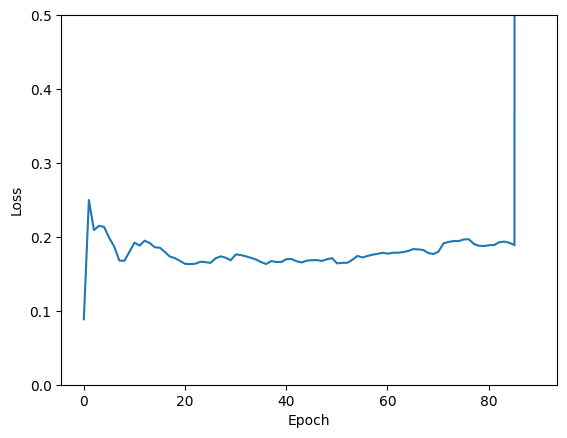

In [ ]:
plt.plot(np.linspace(0, len(train_losses),len(train_losses)), train_losses, label = 'RMSprop')
plt.xlabel("Epoch")
plt.ylabel("Loss")
ax = plt.gca()
ax.set_ylim([0, 0.5])

In [ ]:
print(np.mean(train_losses))
print(train_losses)

nan
[8.58982280e-02 6.95612393e-02 1.02768791e-01 1.02664955e-01
 1.19539800e-01 1.15663476e-01 1.31112265e-01 1.24597020e-01
 1.40771305e-01 1.36595406e-01 1.29154758e-01 1.51666604e-01
 1.52710115e-01 1.53938802e-01 1.54441986e-01 1.55807642e-01
 1.52623307e-01 1.50021800e-01 1.47281504e-01 1.52569625e-01
 1.49364246e-01 1.48390465e-01 1.48238878e-01 1.50535801e-01
 1.48626199e-01 1.48082500e-01 1.44583934e-01 1.52529952e-01
 1.67928771e-01 1.66502399e-01 1.66303685e-01 1.66914885e-01
 1.67090340e-01 1.67770412e-01 1.72242173e-01 1.72321353e-01
 1.71029516e-01 1.71189451e-01 1.70449530e-01 1.69313207e-01
 1.68475608e-01 1.72342226e-01 1.74028272e-01 1.74338251e-01
 1.78223300e-01 1.76108248e-01 1.74943384e-01 1.74029426e-01
 1.76235754e-01 1.77710101e-01 1.78588339e-01 1.78993888e-01
 1.80234461e-01 1.80189164e-01 1.78867643e-01 1.72353006e-01
 1.71818345e-01 1.73328489e-01 1.65864319e-01 1.64982285e-01
 1.66713314e-01 1.68559876e-01 1.71505372e-01 1.71930676e-01
 1.73442867e-01 1.73